In [3]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
'''

This script is meant to take in data exported from OVITO and analyze the displaced particles, count the number of vacancies
present within the crystal sample, measure the track length, calculate the theoretical vacancy density as a function of 
depth into the crystal, and find the track width as a function of track depth into the sample. 

This notebook is a continuous work in progress, and especially the proposed methodology to find the track width may need \
to be modified in the future.

Currently to calculate the number of vacancies we say that it is a 1:1 relationship with the number of displaced atoms, which 
is what we are specifically examining in the code below. 

To find the vacancy density as a function of depth, we take volume slices perpendicular to the direction of the inbound gold
ion and count the number of vacancies in this rectangular region over many different depth options. The starting and ending
points of these rectangles are easily modifiable by changing the starting and ending values in the function input.

To find the track width, we first specify along which axis we want to find the track width and then about the 0-point which the
gold ion was initially shot in on (for example at x = 0 or x = 10 or y = 20) for a particular depth we do a complete 360 degree
rotation about the other two axes and find the atoms which have the shortest radius at that particular point (with a specified 
small tolerance value). The values returned are the predicted radii, so we multiply the answer by 2 in the final plot.

***This is open to being modified since this was a rudimentary idea.***

@author: kmream


'''

### Step 1: Get Data Loaded and Visualized

In [4]:
data1 = pd.read_csv('newtest', sep = " ")
data2 = pd.read_csv('thermal_layer_vers', sep = " ")
data3 = pd.read_csv('10kev_21pico_ters', sep = " ")
data4 = pd.read_csv('20kev_27pico_ters', sep = " ")

data1['x'], data2['x'], data3['x'], data4['x'], = data1['x'].values / 10, data2['x'].values / 10, data3['x'].values / 10, data4['x'].values / 10
data1['y'], data2['y'], data3['y'], data4['y'], = data1['y'].values / 10, data2['y'].values / 10, data3['y'].values / 10, data4['y'].values / 10
data1['z'], data2['z'], data3['z'], data4['z'], = data1['z'].values / 10, data2['z'].values / 10, data3['z'].values / 10, data4['z'].values / 10

data4

,id,type,x,y,z,coordination,step
0,51366,1,0.166585,-2.153460,-1.265880,3,29000.0
1,168764,2,-3.856010,11.394900,-0.396562,3,29000.0
2,170543,1,-2.846630,11.323500,-1.013580,3,29000.0
3,170727,2,-2.607320,11.352600,10.816500,3,29000.0
4,171425,1,-2.238770,11.313400,-1.591570,3,29000.0
...,...,...,...,...,...,...,...
2275,1268129,1,1.252560,-0.530654,1.093230,3,29000.0
2276,1268130,1,0.911680,-0.288679,1.435650,3,29000.0
2277,1268161,1,2.204650,-0.506441,2.040910,2,29000.0
2278,1268167,1,0.825148,0.143464,1.903260,5,29000.0


In [5]:
steps1, steps2, steps3= np.unique(data1['step'].values), np.unique(data2['step'].values), np.unique(data3['step'].values)
steps4 = np.unique(data4['step'].values)

data_1 = data1[data1['step'] == steps1[0]].copy()
data_1 = data_1.sort_values(by = 'id')
data_2 = data2[data2['step'] == steps2[0]].copy()
data_2 = data_2.sort_values(by = 'id')
data_3 = data3[data3['step'] == steps3[0]].copy()
data_3 = data_3.sort_values(by = 'id')
data_4 = data4[data4['step'] == steps4[0]].copy()
data_4 = data_4.sort_values(by = 'id')
data_2

,id,type,x,y,z,coordination,step
0,48222,1,9.91389,-1.875740,1.635250,3,18000.0
1,48493,1,9.30835,-1.176730,-0.251697,3,18000.0
2,48494,1,9.53779,-1.202950,-0.437308,3,18000.0
3,48502,1,9.19941,-1.152980,0.316817,3,18000.0
4,48510,1,9.63139,-1.419120,0.513759,3,18000.0
...,...,...,...,...,...,...,...
361,342202,2,5.66206,-0.521016,-1.425500,1,18000.0
362,342380,1,4.85952,0.099097,-0.961949,3,18000.0
363,342550,1,4.35003,0.566561,-0.163163,3,18000.0
364,342551,1,4.46327,0.418624,-0.590055,3,18000.0


(-6.10934, 10.8777)

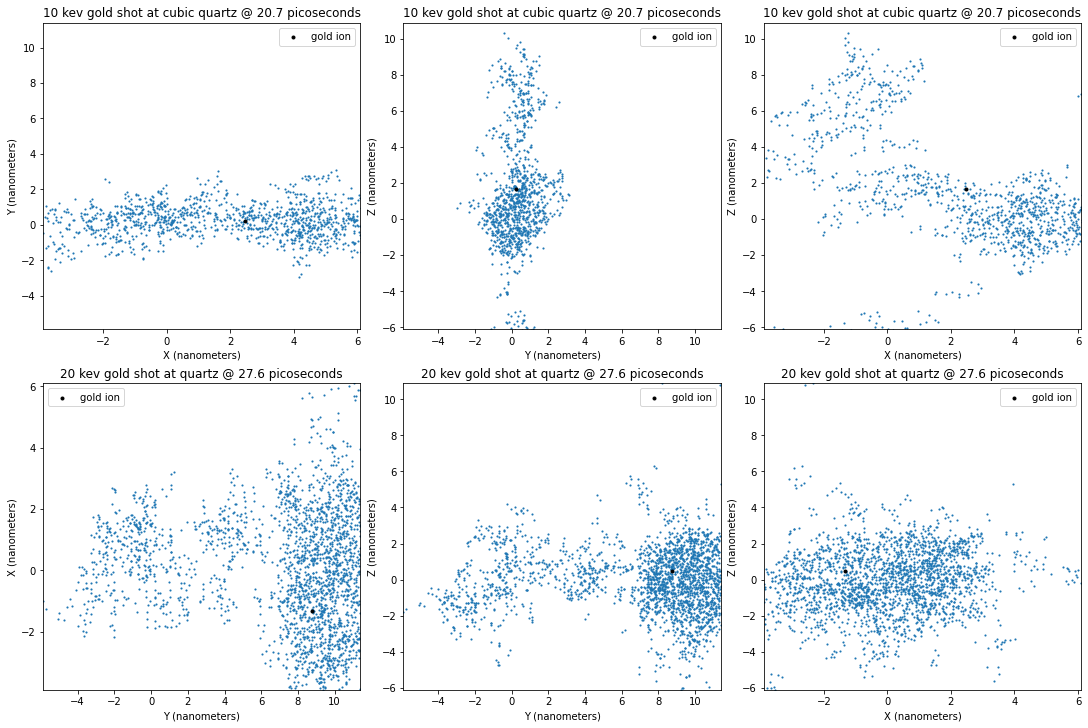

In [6]:
x_min = min(data_4['x'].min(), data_4['x'].min())
x_max = max(data_4['x'].max(), data_4['x'].max())
y_min = min(data_4['y'].min(), data_4['y'].min())
y_max = max(data_4['y'].max(), data_4['y'].max())
z_min = min(data_4['z'].min(), data_4['z'].min())
z_max = max(data_4['z'].max(), data_4['z'].max())

######################################################################################

fig, axes = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)

#axes[0,0].scatter(data_1['x'].values, data_1['y'].values, s = 5, marker = '.')
#axes[0,0].scatter(data_1[data_1['type'] == 3]['x'].values, data_1[data_1['type'] == 3]['y'].values, color = 'black', marker = '.', label = 'gold ion')
#axes[0,0].set_title('gold shot at quartz - no thermal at 60 picoseconds')
#axes[0,0].set_xlabel('X (nanometers)')
#axes[0,0].set_ylabel('Y (nanometers)')
#axes[0,0].legend(loc = 'best')
#axes[0,0].set_xlim(x_min, x_max)
#axes[0,0].set_ylim(y_min, y_max)

#axes[0,1].scatter(data_1['y'].values, data_1['z'].values, s = 5, marker = '.')
#axes[0,1].scatter(data_1[data_1['type'] == 3]['y'].values, data_1[data_1['type'] == 3]['z'].values, color = 'black', marker = '.', label = 'gold ion')
#axes[0,1].set_title('gold shot at quartz - no thermal at 60 picoseconds')
#axes[0,1].set_xlabel('Y (nanometers)')
#axes[0,1].set_ylabel('Z (nanometers)')
#axes[0,1].legend(loc = 'best')
#axes[0,1].set_xlim(y_min, y_max)
#axes[0,1].set_ylim(z_min, z_max)

#axes[0,2].scatter(data_1['x'].values, data_1['z'].values, s = 5, marker = '.')
#axes[0,2].scatter(data_1[data_1['type'] == 3]['x'].values, data_1[data_1['type'] == 3]['z'].values, color = 'black', marker = '.', label = 'gold ion')
#axes[0,2].set_title('gold shot at quartz - no thermal at 60 picoseconds')
#axes[0,2].set_xlabel('X (nanometers)')
#axes[0,2].set_ylabel('Z (nanometers)')
#axes[0,2].legend(loc = 'best')
#axes[0,2].set_xlim(x_min, x_max)
#axes[0,2].set_ylim(z_min, z_max)

######################################################################################

axes[0,0].scatter(data_3['x'].values, data_3['y'].values, s = 5, marker = '.')
axes[0,0].scatter(data_3[data_3['type'] == 3]['x'].values, data_3[data_3['type'] == 3]['y'].values, color = 'black', marker = '.', label = 'gold ion')
axes[0,0].set_title('10 kev gold shot at cubic quartz @ 20.7 picoseconds')
axes[0,0].set_xlabel('X (nanometers)')
axes[0,0].set_ylabel('Y (nanometers)')
axes[0,0].legend(loc = 'best')
axes[0,0].set_xlim(x_min, x_max)
axes[0,0].set_ylim(y_min, y_max)

axes[0,1].scatter(data_3['y'].values, data_3['z'].values, s = 5, marker = '.')
axes[0,1].scatter(data_3[data_3['type'] == 3]['y'].values, data_3[data_3['type'] == 3]['z'].values, color = 'black', marker = '.', label = 'gold ion')
axes[0,1].set_title('10 kev gold shot at cubic quartz @ 20.7 picoseconds')
axes[0,1].set_xlabel('Y (nanometers)')
axes[0,1].set_ylabel('Z (nanometers)')
axes[0,1].legend(loc = 'best')
axes[0,1].set_xlim(y_min, y_max)
axes[0,1].set_ylim(z_min, z_max)

axes[0,2].scatter(data_3['x'].values, data_3['z'].values, s = 5, marker = '.')
axes[0,2].scatter(data_3[data_3['type'] == 3]['x'].values, data_3[data_3['type'] == 3]['z'].values, color = 'black', marker = '.', label = 'gold ion')
axes[0,2].set_title('10 kev gold shot at cubic quartz @ 20.7 picoseconds')
axes[0,2].set_xlabel('X (nanometers)')
axes[0,2].set_ylabel('Z (nanometers)')
axes[0,2].legend(loc = 'best')
axes[0,2].set_xlim(x_min, x_max)
axes[0,2].set_ylim(z_min, z_max)

######################################################################################

axes[1,0].scatter(data_4['y'].values, data_4['x'].values, s = 5, marker = '.')
axes[1,0].scatter(data_4[data_4['type'] == 3]['y'].values, data_4[data_4['type'] == 3]['x'].values, color = 'black', marker = '.', label = 'gold ion')
axes[1,0].set_title('20 kev gold shot at quartz @ 27.6 picoseconds')
axes[1,0].set_xlabel('Y (nanometers)')
axes[1,0].set_ylabel('X (nanometers)')
axes[1,0].legend(loc = 'best')
axes[1,0].set_xlim(y_min, y_max)
axes[1,0].set_ylim(x_min, x_max)

axes[1,1].scatter(data_4['y'].values, data_4['z'].values, s = 5, marker = '.')
axes[1,1].scatter(data_4[data_4['type'] == 3]['y'].values, data_4[data_4['type'] == 3]['z'].values, color = 'black', marker = '.', label = 'gold ion')
axes[1,1].set_title('20 kev gold shot at quartz @ 27.6 picoseconds')
axes[1,1].set_xlabel('Y (nanometers)')
axes[1,1].set_ylabel('Z (nanometers)')
axes[1,1].legend(loc = 'best')
axes[1,1].set_xlim(y_min, y_max)
axes[1,1].set_ylim(z_min, z_max)

axes[1,2].scatter(data_4['x'].values, data_4['z'].values, s = 5, marker = '.')
axes[1,2].scatter(data_4[data_4['type'] == 3]['x'].values, data_4[data_4['type'] == 3]['z'].values, color = 'black', marker = '.', label = 'gold ion')
axes[1,2].set_title('20 kev gold shot at quartz @ 27.6 picoseconds')
axes[1,2].set_xlabel('X (nanometers)')
axes[1,2].set_ylabel('Z (nanometers)')
axes[1,2].legend(loc = 'best')
axes[1,2].set_xlim(x_min, x_max)
axes[1,2].set_ylim(z_min, z_max)

######################################################################################

#axes[2,0].scatter(data_3['x'].values, data_3['y'].values, s = 5, marker = '.')
#axes[2,0].scatter(data_3[data_3['type'] == 3]['x'].values, data_3[data_3['type'] == 3]['y'].values, color = 'black', marker = '.', label = 'gold ion')
#axes[2,0].set_title('gold shot at quartz - with thermal & fixed at 33 picoseconds')
#axes[2,0].set_xlabel('X (angstroms)')
#axes[2,0].set_ylabel('Y (angstroms)')
#axes[2,0].legend(loc = 'best')
#axes[2,0].set_xlim(x_min, x_max)
#axes[2,0].set_ylim(y_min, y_max)

#axes[2,1].scatter(data_3['y'].values, data_3['z'].values, s = 5, marker = '.')
#axes[2,1].scatter(data_3[data_3['type'] == 3]['y'].values, data_3[data_3['type'] == 3]['z'].values, color = 'black', marker = '.', label = 'gold ion')
#axes[2,1].set_title('gold shot at quartz - with thermal & fixed at 33 picoseconds')
#axes[2,1].set_xlabel('Y (angstroms)')
#axes[2,1].set_ylabel('Z (angstroms)')
#axes[2,1].legend(loc = 'best')
#axes[2,1].set_xlim(y_min, y_max)
#axes[2,1].set_ylim(z_min, z_max)

#axes[2,2].scatter(data_3['x'].values, data_3['z'].values, s = 5, marker = '.')
#axes[2,2].scatter(data_3[data_3['type'] == 3]['x'].values, data_3[data_3['type'] == 3]['z'].values, color = 'black', marker = '.', label = 'gold ion')
#axes[2,2].set_title('gold shot at quartz - with thermal & fixed at 33 picoseconds')
#axes[2,2].set_xlabel('X (angstroms)')
#axes[2,2].set_ylabel('Z (angstroms)')
#axes[2,2].legend(loc = 'best')
#axes[2,2].set_xlim(x_min, x_max)
#axes[2,2].set_ylim(z_min, z_max)

### Step 3: Try to quantify number of vacancies

In [7]:
num_vacancies1 = [len(data_1[data_1['step'] == step]) for step in steps1]
num_vacancies2 = [len(data_2[data_2['step'] == step]) for step in steps2]
num_vacancies3 = [len(data_3[data_3['step'] == step]) for step in steps3]
num_vacancies4 = [len(data_4[data_4['step'] == step]) for step in steps4]

'''
it might just be this easy since once we get into the the core of the sample a vacancy arises when a particle is knocked out
there must be a vacancy left behind, but triple check with Emilie to make sure this is correct - otherwise modify 
'''
num_vacancies1
num_vacancies2
num_vacancies3
num_vacancies4

ratio = num_vacancies4[0] / num_vacancies3[0]
ratio
print(f"at 20.7 picoseconds for the 10 keV gold ion there were {num_vacancies3[0]} vacancies")
print(f"at 27.6 picoseconds for the 20 keV gold ion there were {num_vacancies4[0]} vacancies")

at 20.7 picoseconds for the 10 keV gold ion there were 1226 vacancies
at 27.6 picoseconds for the 20 keV gold ion there were 2280 vacancies


### Step 4: Find vacancy density in one specific region

In [8]:
# units of dimensions are in angstroms
x_len1 = np.max(data_1['x'].values) - np.min(data_1['x'].values)
y_len1 = np.max(data_1['y'].values) - np.min(data_1['y'].values)
z_len1 = np.max(data_1['z'].values) - np.min(data_1['z'].values)

x_len2 = np.max(data_2['x'].values) - np.min(data_2['x'].values)
y_len2 = np.max(data_2['y'].values) - np.min(data_2['y'].values)
z_len2 = np.max(data_2['z'].values) - np.min(data_2['z'].values)

x_len3 = np.max(data_3['x'].values) - np.min(data_3['x'].values)
y_len3 = np.max(data_3['y'].values) - np.min(data_3['y'].values)
z_len3 = np.max(data_3['z'].values) - np.min(data_3['z'].values)

x_len4 = np.max(data_4['x'].values) - np.min(data_4['x'].values)
y_len4 = np.max(data_4['y'].values) - np.min(data_4['y'].values)
z_len4 = np.max(data_4['z'].values) - np.min(data_4['z'].values)


volume3, volume4 = ((x_len3) * (y_len3) * (z_len3)), ((x_len4) * (y_len4) * (z_len4))
total_density3, total_density4 = (num_vacancies3 / volume3), (num_vacancies4 / volume4)

#total_density3 = num_vacancies3 / x_len3
print(f"the total density of vacancies in tersoff quartz with 10 keV gold shot after 20.7 picoseconds is {total_density3[0]:.6f} vacancies/nm^3")
print(f"the total density of vacancies in tersoff quartz with 20 keV gold shot after 27.6 picoseconds is {total_density4[0]:.6f} vacancies/nm^3")

the total density of vacancies in tersoff quartz with 10 keV gold shot after 20.7 picoseconds is 0.469907 vacancies/nm^3
the total density of vacancies in tersoff quartz with 20 keV gold shot after 27.6 picoseconds is 0.777081 vacancies/nm^3


In [9]:
''' basic generalized formula as of this moment to find vacancy density at a particular slice from yz-plane of desired thickness '''

def vacancy_vs_depth(data, start, end, one_len, two_len): #this works best for one timestep - can modify in the future if needed
    depth = start - end #starting and ending points specified, where start here is specified as the entrance on the right side
    vol = depth * one_len * two_len  # this takes into account a slice of the entire yz-plane at some depth in the x-direction
    num_vacancy = len(data)
    result = num_vacancy / vol
    return result

In [18]:
x_start1, x_end1 = np.max(data_1['x'].values), np.min(data_1['x'].values)
data_input1 = data_1[data_1['step'] == steps1[0]]

x_start2, x_end2 = np.max(data_2['x'].values), np.min(data_2['x'].values)
data_input2 = data_2[data_2['step'] == steps2[0]]

x_start3, x_end3 = np.max(data_3['x'].values), np.min(data_3['x'].values)
y_start3, y_end3 = np.max(data_3['y'].values), np.min(data_3['y'].values)
data_input3 = data_3[data_3['step'] == steps3[0]]

x_start4, x_end4 = np.max(data_4['x'].values), np.min(data_4['x'].values)
y_start4, y_end4 = np.max(data_4['y'].values), np.min(data_4['y'].values)
data_input4 = data_4[data_4['step'] == steps4[0]]

result1, result2 = vacancy_vs_depth(data_input1, x_start1, x_end1, y_len1, z_len1), vacancy_vs_depth(data_input2, x_start2, x_end2, y_len2, z_len2)
result3, result4 = vacancy_vs_depth(data_input3, x_start3, x_end3, y_len3, z_len3), vacancy_vs_depth(data_input4, x_start4, x_end4, y_len4, z_len4)
print(f"vacancy density in tersoff sample with 10 keV gold ion at depth {x_start3 - x_end3} angstroms after 20.7 picoseconds is {result3:.6f} vacancies/nm^3") #done for each timestep 
print(f"vacancy density in tersoff sample at depth {x_start4 - x_end4} angstroms after 20.7 picoseconds is {result4:.6f} vacancies/nm^3") #done for each timestep 

vacancy density in tersoff sample with 10 keV gold ion at depth 10.94283 angstroms after 20.7 picoseconds is 0.469907 vacancies/nm^3
vacancy density in tersoff sample at depth 9.98838 angstroms after 20.7 picoseconds is 0.777081 vacancies/nm^3


In [11]:
print(x_start3, x_end3)
print(y_start4, y_end4)

6.59516 -4.34767
11.3992 -5.89321


### Step 6: Make a plot for differing depths what are the predicted vacancy densities (with error to be added soon)

In [69]:
x_end_options = [.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 6.0]
y_end_options1 = [-12, -10, -8, -6, -4, -2, -0.5, 0.5, 1.0, 2.0, 3.0]
y_end_options2 = [-12, -10, -8, -6, -4, -2, -0.5, 0.5, 1.0, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]

result1 = [vacancy_vs_depth(data_input1, x_start1, x_end, y_len1, z_len1) for x_end in x_end_options]
result2 = [vacancy_vs_depth(data_input2, x_start2, x_end, y_len2, z_len2) for x_end in x_end_options]
result3 = [vacancy_vs_depth(data_input3, y_start3, y, x_len3, z_len3) for y in y_end_options1]
result4 = [vacancy_vs_depth(data_input4, y_start4, y, x_len4, z_len4) for y in y_end_options2]

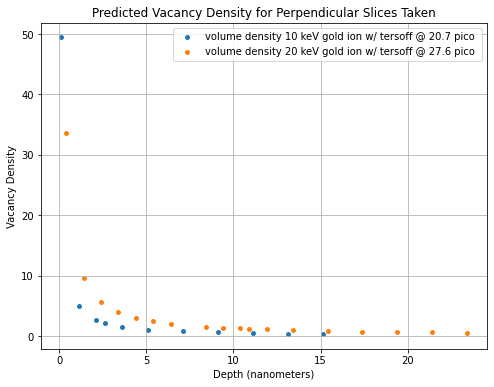

In [70]:
plt.figure(figsize=(8, 6))
y_values3, y_values4 = [y_start3 - y for y in y_end_options1], [y_start4 - y for y in y_end_options2]

#plt.scatter(x_values1, result1, label = f'gold with thermal @ 60 pico', s = 15)
#plt.scatter(x_values3, result3, label = '10 keV gold ion w/ tersoff @ 20.7 pico', s = 15)
plt.scatter(y_values3, result3, label = 'volume density 10 keV gold ion w/ tersoff @ 20.7 pico ', s = 15)
plt.scatter(y_values4, result4, label = 'volume density 20 keV gold ion w/ tersoff @ 27.6 pico ', s = 15)
plt.title(f'Predicted Vacancy Density for Perpendicular Slices Taken')
plt.xlabel('Depth (nanometers)')
plt.ylabel('Vacancy Density')
plt.legend(loc = 'best')
plt.grid(True)

### Step 7: Try to find track width and length at different depths

In [71]:
def find_spacing(end, ref1, ref2, data, axis='x', sigma_1=0.1, sigma_2=0.1):
    """
    Generalized function to calculate track width at a given depth along a specified axis.
    
    Parameters:
    - end: float, defines the depth cutoff value.
    - ref1, ref2: float, reference coordinates for the plane perpendicular to the axis.
    - data: DataFrame, contains columns 'x', 'y', 'z'.
    - axis: str, one of 'x', 'y', 'z' — the primary direction of ion penetration.
    - sigma_1, sigma_2: float, uncertainties in ref1 and ref2 respectively.
    """
    # Axis mapping
    axes = ['x', 'y', 'z']
    assert axis in axes, "Axis must be 'x', 'y', or 'z'"
    
    perp_axes = [ax for ax in axes if ax != axis]
    axis_max = np.max(data[axis].values)
    depth = axis_max - end

    # Filter for depth (slight tolerance)
    filtered_data = data[np.isclose(data[axis], depth, atol=0.2)]
    if filtered_data.empty:
        print(f"No particles found at {axis} = {depth} (end = {end})")
        return [], [], [], []

    degree_spacing = np.linspace(0, 360, 361)  # 1-degree increments
    coord1_values, coord2_values, width_at_depth, error_at_depth = [], [], [], []

    for theta in degree_spacing:
        theta_rad = np.radians(theta)

        d1 = np.cos(theta_rad)
        d2 = np.sin(theta_rad)

        # Radial distances from (ref1, ref2) in the plane perpendicular to axis
        distances = np.sqrt((filtered_data[perp_axes[0]] - ref1) ** 2 +
                            (filtered_data[perp_axes[1]] - ref2) ** 2)

        if distances.empty:
            continue

        min_idx = np.argmin(distances)
        coord1 = filtered_data.iloc[min_idx][perp_axes[0]]
        coord2 = filtered_data.iloc[min_idx][perp_axes[1]]
        coord1_values.append(coord1)
        coord2_values.append(coord2)

        min_distance = distances.iloc[min_idx]
        error_distance = np.sqrt(
            ((coord1 - ref1) / min_distance) ** 2 * sigma_1 ** 2 +
            ((coord2 - ref2) / min_distance) ** 2 * sigma_2 ** 2)
        error_at_depth.append(error_distance)

    if coord1_values and coord2_values:
        width_at_depth.append(np.min(distances))  # minimal radius at this depth
        mean_error = np.mean(error_at_depth)
    else:
        mean_error = None

    return coord1_values, coord2_values, width_at_depth, mean_error

In [86]:
#test out function validity
y_width_options = [1.0, 2.3, 3.2, 3.9]
y_widths3 = [y_start3 - y for y in y_width_options]
y_widths4 = [y_start4 - y for y in y_width_options]

sigma_y3, sigma_z3 = np.std(data_3['y'].values), np.std(data_3['z'].values)
sigma_y4, sigma_z4 = np.std(data_4['y'].values), np.std(data_4['z'].values)

attemptx3, attemptz3, attemptdist3, attempterr3 = zip(*[
    find_spacing(y_end, 0, 0, data_input3, axis='y', sigma_1=sigma_y3, sigma_2=sigma_z3)
    for y_end in tqdm(y_width_options, desc="Track width - data_input3")])

attemptx4, attemptz4, attemptdist4, attempterr4 = zip(*[
    find_spacing(y_end, 0, 0, data_input4, axis='y', sigma_1=sigma_y4, sigma_2=sigma_z4)
    for y_end in tqdm(y_width_options, desc="Track width - data_input4")])


Track width - data_input3: 100%|██████████| 4/4 [00:00<00:00,  8.64it/s]

Track width - data_input4: 100%|██████████| 4/4 [00:00<00:00,  8.98it/s]


/var/folders/8_/7cxg7b591zn267gy4zwgyw6h0000gn/T/ipykernel_1838/729933480.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best', fontsize='small')


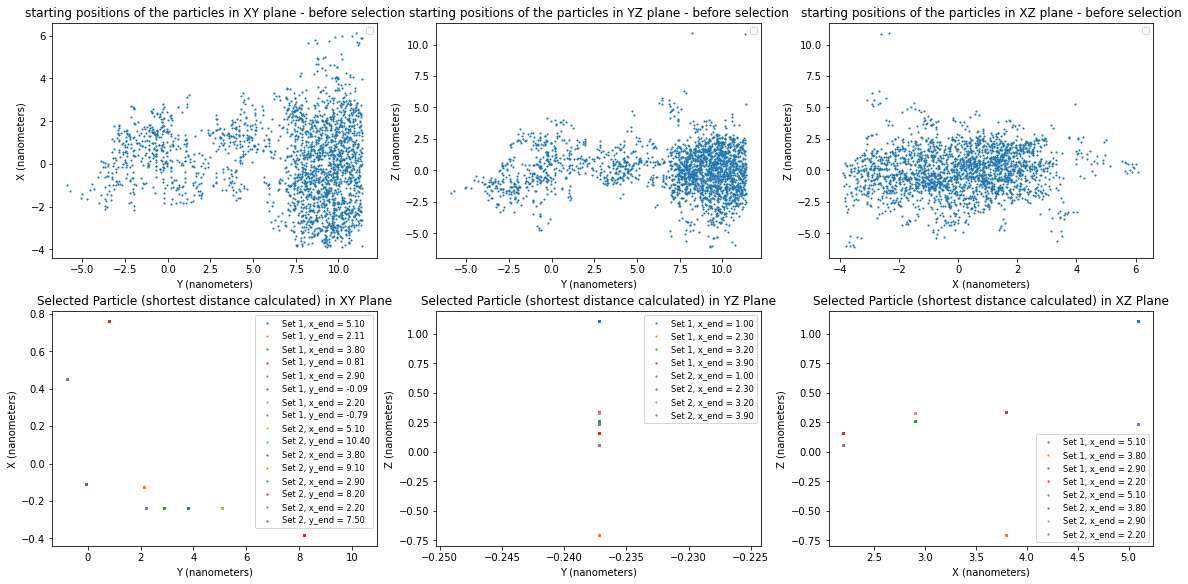

In [88]:
# Create the subplots

fig, axes = plt.subplots(2, 3, figsize=(16, 8), constrained_layout=True)

# Initial plots
axes[0,0].scatter(data_4['y'].values, data_4['x'].values, s = 5, marker = '.')
axes[0,0].set_title('starting positions of the particles in XY plane - before selection')
axes[0,0].set_xlabel('Y (nanometers)')
axes[0,0].set_ylabel('X (nanometers)')

axes[0,1].scatter(data_4['y'].values, data_4['z'].values, s = 5, marker = '.')
axes[0,1].set_title('starting positions of the particles in YZ plane - before selection')
axes[0,1].set_xlabel('Y (nanometers)')
axes[0,1].set_ylabel('Z (nanometers)')

axes[0,2].scatter(data_4['x'].values, data_4['z'].values, s = 5, marker = '.')
axes[0,2].set_title('starting positions of the particles in XZ plane - before selection')
axes[0,2].set_xlabel('X (nanometers)')
axes[0,2].set_ylabel('Z (nanometers)')

attempty_sets = [attemptx3, attemptx4]
attemptz_sets = [attemptz3, attemptz4]
attemptdist_sets = [attemptdist3, attemptdist4]
y_end_sets = [y_width_options, y_width_options]
y_start_sets = [y_start3, y_start4]

for set_idx, (attx, attz, attd, y_ends, y_start) in enumerate(zip(attempty_sets, attemptz_sets, attemptdist_sets, y_end_sets, y_start_sets)):
    for i, (x_vals, z_vals, d_vals) in enumerate(zip(attx, attz, attd)):
        # Calculate x_values only for this specific loop
        Ex_values = x_start - np.array(x_ends)  # Make sure x_values is based on `x_ends`
        y_values = y_start - np.array(y_ends)  # Make sure x_values is based on `x_ends`
        
        # Plot XY
        axes[1,0].invert_xaxis()
        axes[1,0].scatter([x_values[i]] * len(y_vals), y_vals, s=5, marker='.',
                          label=f"Set {set_idx+1}, x_end = {x_values[i]:.2f}")
        
        axes[1,0].scatter([y_values[i]] * len(x_vals), x_vals, s=5, marker='.',
                          label=f"Set {set_idx+1}, y_end = {y_values[i]:.2f}")
        
        # Plot YZ
        axes[1,1].scatter(y_vals, z_vals, s=5, marker='.',
                          label=f"Set {set_idx+1}, x_end = {x_ends[i]:.2f}")
        
        # Plot XZ
        axes[1,2].invert_xaxis()
        axes[1,2].scatter([x_values[i]] * len(z_vals), z_vals, s=5, marker='.',
                          label=f"Set {set_idx+1}, x_end = {x_values[i]:.2f}")


# Set titles and labels
axes[1,0].set_title('Selected Particle (shortest distance calculated) in XY Plane')
axes[1,0].set_xlabel('Y (nanometers)')
axes[1,0].set_ylabel('X (nanometers)')

axes[1,1].set_title('Selected Particle (shortest distance calculated) in YZ Plane')
axes[1,1].set_xlabel('Y (nanometers)')
axes[1,1].set_ylabel('Z (nanometers)')

axes[1,2].set_title('Selected Particle (shortest distance calculated) in XZ Plane')
axes[1,2].set_xlabel('X (nanometers)')
axes[1,2].set_ylabel('Z (nanometers)')

# Add legends
for ax in axes.flat:
    ax.legend(loc='best', fontsize='small')

### Step 8: Recreate the irradiated gold sample plot with error bars to find track width vs depth

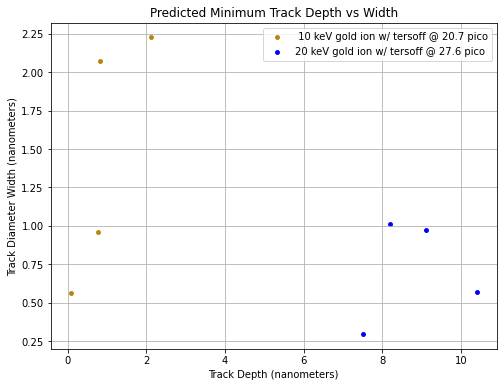

In [91]:
track_depths3 = [abs(y_start3 - y) for y in y_width_options]
track_depths4 = [abs(y_start4 - y) for y in y_width_options]

attemptdist3, attemptdist4 = np.array(attemptdist3).flatten(), np.array(attemptdist4).flatten()
attempterr3, attempterr4 = np.array(attempterr3).flatten(), np.array(attempterr4).flatten()

fig = plt.figure(figsize=(8, 6))
#plt.scatter(x_values1, attemptdist1, label = f'gold within quartz 50 picoseconds', s = 15)
#plt.scatter(x_values2, attemptdist2, label = f'gold outside quartz 80 picoseconds', s = 15)
plt.scatter(track_depths3, 2*attemptdist3, color = "darkgoldenrod", label = f' 10 keV gold ion w/ tersoff @ 20.7 pico', s = 15)
plt.scatter(track_depths4, 2*attemptdist4, color = "blue", label = f'20 keV gold ion w/ tersoff @ 27.6 pico', s = 15)
#plt.errorbar(x_widths3, attemptdist3, yerr=attempterr3, fmt='o', color = "darkgoldenrod", markersize=2, label="Vashistha Error")
#plt.errorbar(x_widths4, attemptdist4, yerr=attempterr4, fmt='o', color= "cornflowerblue", markersize=2, label="Tersoff Error")
plt.title(f'Predicted Minimum Track Depth vs Width')
plt.xlabel('Track Depth (nanometers)')
plt.ylabel('Track Diameter Width (nanometers)')
plt.legend(loc = 'best')
plt.grid(True)

#see if there is a variable I can output from lammps that tracks the kinetic energy of the gold ion at each time step - should be able to

array([13.21467145, 11.66494773, 13.53619949, 13.61128715])

### Step 9: Subtract the displaced atoms from the original configuration to visualize what the created track would more realistically look like!

In [ ]:
'''

this is a come se dice tomorrow problem

'''

In [ ]:
#can make plot with recoil energy/length vs width from TEM images